In [1]:
import torch
import torchvision.models as models
from torchvision import datasets, models, transforms
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import os
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [25]:
import os

data_dir = 'data/hymenoptera_data'

image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ['train', 'val']
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=5,
        shuffle=True, num_workers=4
    )
    for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device: ", device)

device:  cuda:0


# Training 

In [26]:
model_resnet = torchvision.models.resnet18(pretrained=True)

# Freeze the network
# for param in model_resnet.parameters():
#     param.requires_grad = False

num_ftrs = model_resnet.fc.in_features
print("Original # features: ", num_ftrs)

model_resnet.fc = nn.Linear(num_ftrs, 512)
# model_resnet = model_resnet.to(device)

Original # features:  512


In [27]:
from torchsummary import summary

# summary(model_resnet, (3, 224, 224))
# del model_resnet.fc
# del model_resnet.avgpool

# print("Last Dim: ", model_resnet.layer2[-1].conv2)

print("Last Dim: ", model_resnet.fc)

Last Dim:  Linear(in_features=512, out_features=512, bias=True)


# Calculate Conv Output 
$$
[(W−K+2P)/S]+1
$$
or
$$
W - (K-1)
$$

- $W$: input volume
- $K$: kernel size
- $p$: padding
- $s$: stride

In [28]:
input_size = 32
kernel_size = 5
strides = 1
padding = 0

# deconv
output_size = strides * (input_size-1) + kernel_size - 2*padding
output_size

36

In [50]:
import torch.nn.functional as F

class Autoencoder(nn.Module):
    def __init__(self, z_dim, model_resnet):
        super(Autoencoder, self).__init__()

        self.encoder = model_resnet

        self.decFC1 = nn.Linear(z_dim, 15*15*30)
        self.decConv1 = nn.ConvTranspose2d(30, 512, kernel_size=2, stride=2, padding=1, bias=False)
        self.decConv2 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False)
        self.decConv3 = nn.ConvTranspose2d(256, 64, kernel_size=4, stride=2, padding=1, bias=False)
        self.decConv4 = nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False)

    def forward(self, x):
        x = F.relu(self.encoder(x))

        x = F.relu(self.decFC1(x))
        x = x.view(-1, 30, 15, 15)
        x = F.relu(self.decConv1(x))
        x = F.relu(self.decConv2(x))
        x = F.relu(self.decConv3(x))
        x = torch.sigmoid(self.decConv4(x))
        return x


In [51]:
model_ae = Autoencoder(512, model_resnet)
model_ae = model_ae.to(device)

In [52]:
# print(model_autoencoder)
summary(model_ae, (3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─ResNet: 1-1                            [-1, 512]                 --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        128
|    └─ReLU: 2-3                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
|    └─Sequential: 2-5                   [-1, 64, 56, 56]          --
|    |    └─BasicBlock: 3-1              [-1, 64, 56, 56]          73,984
|    |    └─BasicBlock: 3-2              [-1, 64, 56, 56]          73,984
|    └─Sequential: 2-6                   [-1, 128, 28, 28]         --
|    |    └─BasicBlock: 3-3              [-1, 128, 28, 28]         230,144
|    |    └─BasicBlock: 3-4              [-1, 128, 28, 28]         295,424
|    └─Sequential: 2-7                   [-1, 256, 14, 14]         --
|    |    └─BasicBlock: 3-5              [-1, 256, 14, 14]     

Layer (type:depth-idx)                   Output Shape              Param #
├─ResNet: 1-1                            [-1, 512]                 --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        128
|    └─ReLU: 2-3                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
|    └─Sequential: 2-5                   [-1, 64, 56, 56]          --
|    |    └─BasicBlock: 3-1              [-1, 64, 56, 56]          73,984
|    |    └─BasicBlock: 3-2              [-1, 64, 56, 56]          73,984
|    └─Sequential: 2-6                   [-1, 128, 28, 28]         --
|    |    └─BasicBlock: 3-3              [-1, 128, 28, 28]         230,144
|    |    └─BasicBlock: 3-4              [-1, 128, 28, 28]         295,424
|    └─Sequential: 2-7                   [-1, 256, 14, 14]         --
|    |    └─BasicBlock: 3-5              [-1, 256, 14, 14]     

In [49]:
criterion = nn.MSELoss()
# criterion = nn.BCELoss()

# optimizer_conv = optim.SGD(model_resnet.fc.parameters(), lr=0.001, momentum=0.9)
optimizer_conv = optim.SGD(model_ae.parameters(), lr=0.01, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [39]:
from utils import train_model

model_ae = train_model(
    model_ae, criterion, optimizer_conv,
    exp_lr_scheduler, device, dataloaders,
    dataset_sizes, num_epochs = 10
)

Epoch 0/9
----------
train Loss: 1.7475
val Loss: 1.6524

Epoch 1/9
----------
train Loss: 1.7741
val Loss: 1.6524

Epoch 2/9
----------
train Loss: 1.7529
val Loss: 1.6523

Epoch 3/9
----------
train Loss: 1.7064
val Loss: 1.6523

Epoch 4/9
----------
train Loss: 1.7575
val Loss: 1.6523

Epoch 5/9
----------
train Loss: 1.7585
val Loss: 1.6522

Epoch 6/9
----------
train Loss: 1.7412
val Loss: 1.6522

Epoch 7/9
----------
train Loss: 1.7389
val Loss: 1.6522

Epoch 8/9
----------
train Loss: 1.7427
val Loss: 1.6522

Epoch 9/9
----------
train Loss: 1.7478
val Loss: 1.6522

Training complete in 1m 28s
Best val Acc: 1.652155


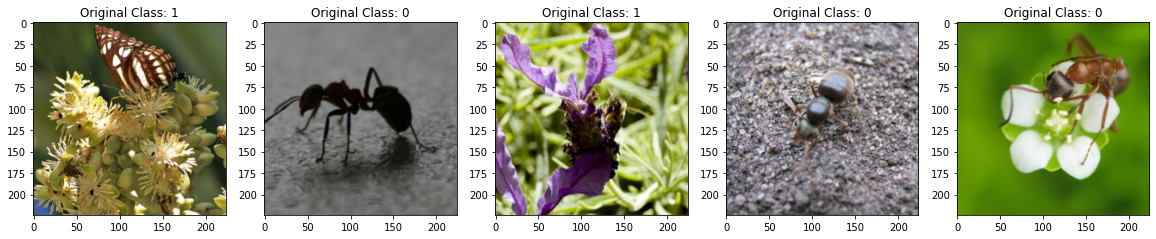

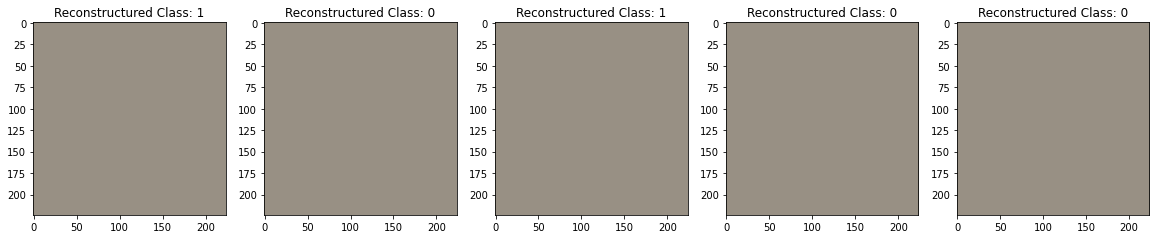

In [41]:
import matplotlib.pyplot as plt
import random

model_ae.eval()
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

with torch.no_grad():
    batch_data, batch_lables = next(iter(dataloaders['val']))

    # Original
    plt.figure(figsize=(20, 5))
    for i, img in enumerate(batch_data):
        img = img.cpu().numpy().transpose((1, 2, 0))
        img = std * img + mean
        plt.subplot(1, len(batch_data), i + 1)
        plt.title(f"Original Class: {batch_lables[i]}")
        plt.imshow((img * 255).astype(np.uint8))
    plt.show()


    # Reconstruct
    batch_data = batch_data.to(device)
    out_imgs = model_ae(batch_data)
    plt.figure(figsize=(20, 5))
    for i, img in enumerate(out_imgs):
        img = img.cpu().numpy().transpose((1, 2, 0))
        img = std * img + mean
        plt.subplot(1, len(batch_data), i + 1)
        plt.title(f"Reconstructured Class: {batch_lables[i]}")
        plt.imshow((img * 255).astype(np.uint8))

    plt.show()